# Denoising Diffusion Model

This numerical tours explains denoising diffusion model on a simple 1-D example. The density to sample from is a mixture of Gaussian, so that the diffused densities can be computed in closed form.

To learn more about diffiusion model, you can have a look at [Valentin de Bortoli courses's slides](https://vdeborto.github.io/project/generative_modeling/). I have written [a short mathematical memo here](https://mathematical-tours.github.io/book-sources/optim-ml/OptimML-DiffusionModels.pdf).

Note that this tours uses [JAX](https://github.com/google/jax) (to compute the gradient of the closed form expression for the score, but this can be instead coded by hand if needed) and [FLAX](https://github.com/google/flax) for the last part (implementing a MLP for score matching).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## Mixture of Gaussians
In order to be able to have closed form formula for the flows simulated bellow, we consider 1-D mixtures of Gaussians $\sum_i a_i \mathcal{N}(\mu_i,\sigma_i^2)$ parameterized by $(a,\mu,\sigma)$.
We define their density functions and a sampling operator.

In [2]:
def gauss(x,m,s): return 1/( jnp.sqrt(2*jnp.pi) * s ) * jnp.exp( -(x-m)**2 / (2*s**2) )
def gaus_mixture(x,mu,sigma,a):
    y = x*0
    for i in range(len(mu)):
        y = y + a[i] * gauss(x,mu[i],sigma[i])
    return y
def sample_mixture(P, mu,sigma,a):  
    key = jax.random.PRNGKey(0)  
    key, subkey = jax.random.split(key)
    I = jax.random.choice(subkey, jnp.arange(0, len(a)), shape=(P,1), p=a)
    key, subkey = jax.random.split(key)
    return ( mu[I] + jax.random.normal(subkey, (P,1))*sigma[I] ).flatten()


Define also helpers for the display of histograms and trajectories.

In [3]:
fs = (6, 3)
xmax = 3
nbins = 200
def display_histogram(X0):
    h0,b = np.histogram(X0.flatten(), bins=nbins, range=[-xmax, xmax])
    plt.bar( np.linspace(-xmax,xmax,nbins), h0/P * nbins/(2*xmax), width=2*xmax/(nbins-1), align='center', color='red')
def display_trajectories(Y, m = 1000, alpha=.3, linewidth=.2):  # m=number of trajectories to display
    disp_ind = np.round( np.linspace(0,P-1,m) ).astype(jnp.int32)
    I = np.argsort(Y[:,-1])
    Y = Y[I,:]
    for i in range(m):
        k = disp_ind[i]
        s = k/(P-1)
        plt.plot( np.linspace(0,T,N), Y[k,:], color=[s,0,1-s], alpha=alpha, linewidth=linewidth )

Define a measure $\rho_0(x)$ defined as a mixture and display.

In [4]:
mu = jnp.array([-.7, 0, .5])*3 # mean
sigma = jnp.array([.02, .05, .03])*9 # std
a = jnp.array([2, 3, 2]) # weight, should sum to 1
a = a/jnp.sum(a)
def rho0(x): return gaus_mixture(x,mu,sigma,a)

Evaluate the density on a grid and display it.

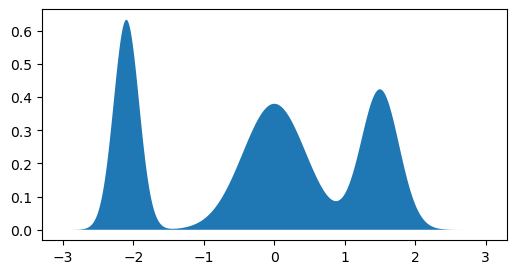

In [5]:
x = jnp.linspace(-xmax,xmax,1000)
plt.figure(figsize=fs)
plt.fill_between(x,rho0(x));

## Langevin sampling

Blabla.

To sample from a density $\rho_0(x)$, Langevin diffusion performs a gradient descent on the negative log-density, which reads, for a step size $\tau>0$, 
$$
    X_{k+1} :=  X_k + \tau \eta_0(X_k) + \sqrt{2\tau}W_k
$$ 
where the $W_{k} \sim \mathcal{N}(0,\text{Id})$ are i.d.d. Gaussian white noise, and where the ``non-smoothed'' (we will introduced its smoothed version later) score reads
$$
    \eta_0(x) := \nabla \log \rho_0(x) = \frac{\nabla \rho_0(x)}{\rho_0(x)}.
$$

When $\tau \rightarrow 0$, this corresponds to the following Langevin SDE
$$
    d X_t = \eta_0(X_t) d t + \sqrt{2\tau} d W_t
$$
where $W_t$ is a Wiener process. 

One can show that the law of $X_T$ converges in law toward $\rho_0$.

We first compute and display this score.

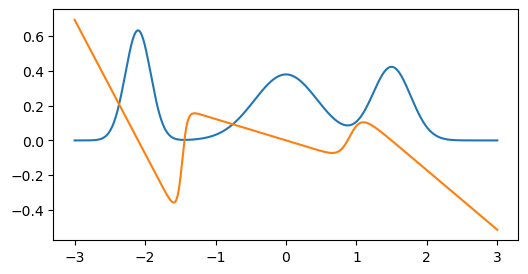

In [6]:
grad_rho0 = jax.grad(rho0)
grad_rho0_vec = jnp.vectorize(grad_rho0)
def eta0(x): return grad_rho0_vec(x) / rho0(x)
plt.figure(figsize=fs)
plt.plot(x,rho0(x))
plt.plot(x,eta0(x)/40);

Sample $Z_0$ from the initial density at time $t=0$, which is uniform on $[-w/2,w/2]$. 

In [7]:
P = 50000 # number of particles
key = jax.random.PRNGKey(666)
w = 6 # support of the indicator
Z0 = w*jax.random.uniform(key, (P,))-w/2

Run the recursion of Langevin.

In [8]:
T = 10 # final time
N = 5000 # number of steps
tau = T / N # step size

def step(carry, _):
    x_prev, key = carry
    key, subkey = jax.random.split(key)
    x_next = x_prev + tau * eta0(x_prev) + jnp.sqrt(2 * tau) * jax.random.normal(subkey, (P,))
    return (x_next, key), x_next

# Initialize PRNG key
key = jax.random.PRNGKey(666)
# Perform scan
_, Z = jax.lax.scan(step, (Z0, key), jnp.arange(1, N))
# Add initial condition as the first column
Z = jnp.column_stack((Z0, Z.T))

Display evolving empirical densities by showing the histograms of the samples.

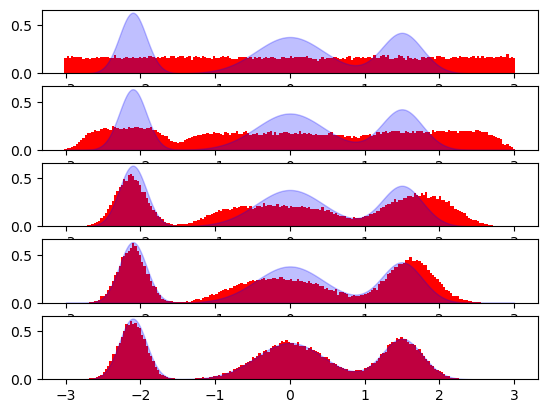

In [9]:
disp_ind = ( jnp.array([0, .001, .005, .01, 1])*N ).astype(jnp.int32) 
for i in range(len(disp_ind)):
    k = disp_ind[i]
    plt.subplot(len(disp_ind),1,i+1)
    display_histogram(Z[:,k])
    plt.fill_between(x, rho0(x), color=[0,0,1,.25] )

Display sample path $t \mapsto X_t$.

/Users/gpeyre/miniconda3/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


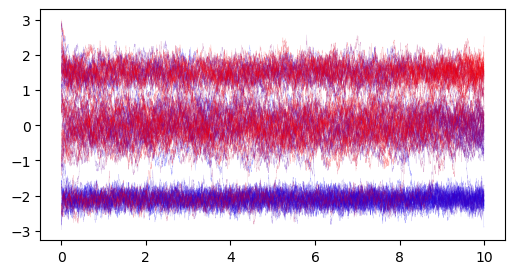

In [10]:
plt.figure(figsize=fs)
display_trajectories(Z, m=100)

## Forward noising process

The two major issues with Langevin is that it converges slowly for singular $\eta_0$ (in particular with highly non concave log-density) and that it needs $\eta_0$ to be known in closed form or estimated. For applications to generative model, this is unacceptable, because $\rho_0$ is only known approximately from sample. It is very hard to estimate $\eta_0$ from sample, but as we will see, it is possible to instead estimated smoothed version of it. Diffusion model leverage this by replacing Lancegin sampling by another sampling method that rely on such smoothed score. 

This sampling method is achieved by inversing a forward ``noising process''. We consider the following noising model
$$
    d X_t = -X_t + \sqrt{2} dW_t
$$
where $W_t$ is a Wiener process. From the knowledge of $X_0$, the law $\rho_t$ of $X_t$ can be computed exactly as the law of
$$
    X_t \sim  e^{-t} X_0 + \sqrt{1-e^{-2t}} Z
$$
where $Z \sim \mathcal{N}(0,1)$.

In the case of a mixture of Gaussian considered here, 
$$
    X_0 \sim \rho_0 \triangleq \sum_i a_i \mathcal{N}(\mu_i,\sigma_i^2)
$$
the law of $X_t$ can thus be computed exactly in closed form as 
$$
    X_t \sim \rho_t \triangleq \sum_i a_i \mathcal{N}(e^{-t} \mu_i, e^{-2t} \sigma_i^2 + 1-e^{-2t})
$$


In [11]:
def rho(x,t):
    sigma_t = jnp.sqrt( jnp.exp(-2*t)*sigma**2 + 1 -  jnp.exp(-2*t) )
    return gaus_mixture(x, mu*jnp.exp(-t), sigma_t,a)

Display evolution with $t$ of the density $\rho_t(x)$

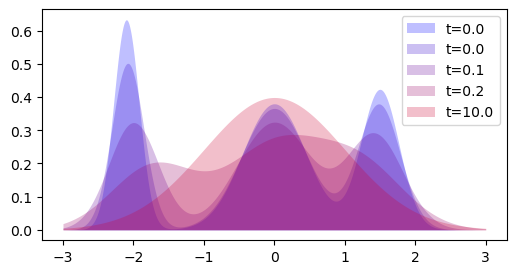

In [12]:
plt.figure(figsize=fs)
t_list = jnp.array([0, .1, .5, 2, 100])/10
for i in range(len(t_list)):
    s = i/len(t_list)
    t = t_list[i]
    plt.fill_between(x,rho(x,t), color=[s,0,1-s, .25], label=f't={t:.1f}', linewidth=0 )
plt.legend();

We first generate $P$ sample $X_0$ from the mixture of Gaussian at time $t=0$, and compare the associated empirical histogram with the density.

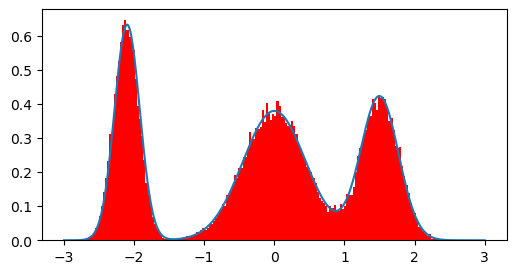

In [13]:
X0 = sample_mixture(P, mu,sigma,a)
plt.figure(figsize=fs)
display_histogram(X0)
plt.plot( x, gaus_mixture(x,mu,sigma,a) ) ;

The forward noising process is computed numerically approximately with using an Euler-Maruyama scheme
$$
    X_{k+1} = X_k - \tau X_k  + \sqrt{2\tau} W_k,
$$
where $W_k$ are i.i.d. white noises.

Set the final time $T$, which should be large enough so that the final distribution of $X_T$ is approximately $\mathcal{N}(0,1)$.

In [14]:
T = 2 # final time
N = 3000 # number of steps
tau = T / N # step size

Now run the recursion.

In [15]:
def step(carry, _):
    x_prev, key = carry
    key, subkey = jax.random.split(key)
    x_next = x_prev - tau * x_prev + jnp.sqrt(2 * tau) * jax.random.normal(subkey, (P,))
    return (x_next, key), x_next

# Initialize PRNG key
key = jax.random.PRNGKey(666)
# Perform scan
_, X = jax.lax.scan(step, (X0, key), jnp.arange(1, N))
# Add initial condition as the first column
X = jnp.column_stack((X0, X.T))

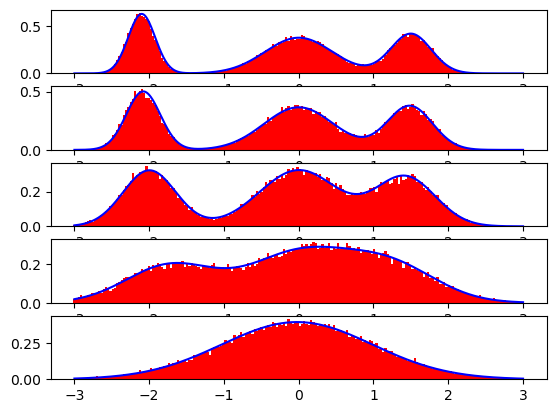

In [16]:
# display evolving density
t_list = jnp.array([0, .01, .05, .2, T])
for i in range(len(t_list)):
    s = i/len(t_list)
    t = t_list[i]
    k = np.round( t/tau ).astype(jnp.int32) 
    plt.subplot(len(t_list),1,i+1)
    plt.plot(x,rho(x,t), color='blue' )
    display_histogram(X[:,k])

## Reverse diffusion 

The score is the vector field
$$
    \nabla \log(\rho(x,t)) = \frac{\nabla \rho(x,t)}{\rho(x,t)}.
$$
Informally, it points toward regions of high densities. 

Since here $\rho(x,t)$ can be computed in closed form, the score can itself be computed in closed form. Of course, in real situation, it is impossible, and we will see in the next section how to approximate it numerically from sampled of $\rho(x,t)$. 


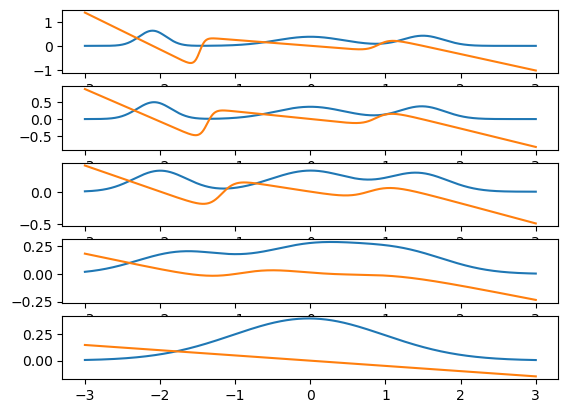

In [17]:
grad_rho = jax.grad(rho)
grad_rho_vec = jnp.vectorize(grad_rho)
def score(x,t): return grad_rho_vec(x, t) / rho(x,t)
for i in range(len(t_list)):
    s = i/len(t_list)
    t = t_list[i]
    plt.subplot(len(t_list),1,i+1)
    plt.plot( x, rho(x, t) )
    plt.plot( x, score(x, t) / 20 )

The actual sampling (the generative process) is now done by reverting in time this process, i.e., for a large enough $T \gg 0$, one seeks to approximate $X_{T-t}$. 

The main result of diffusion model is that the law of $X_{T-t}$ is exaclty equal to the law of $Y_t$ satisfying the following Langevin SDE, initialized with $Y_0=X_T$
$$
	\mathrm{d} Y_t = [ Y_t + (1+\alpha) \nabla \log(\rho_{T-t})(Y_t) ] \mathrm{d} t + \sqrt{2 \alpha} \mathrm{d} W_t
$$
where $\alpha \geq 0$ is a parameter controlling the randomness introduced during the bacwkard flow.
This can be discretized using an Euler-Maruyama scheme, starting from $Y_0=X_{T/\tau}$
$$
	Y_{k+1} = Y_k + \tau Y_t + (1+\alpha) \nabla \log(\rho_{T-t})(Y_t)  + \sqrt{2\tau\alpha} W_k. 
$$

The case $\alpha=1$ is the one used in diffusion model. Setting different value of $\alpha$ is equivalent to changing the time of the diffusion. The case $\alpha=0$ corresponds to a singular limit which is only random at $Y_0$ but after follow an advection equation
$$
	\frac{\mathrm{d} Y_t}{\mathrm{d} t} = Y_t + \nabla \log(\rho_{T-t})(Y_t)
$$

Sample $Y_0$ from the stationary distribution $\mathcal{N}(0,1)$. Since we are in 1-D, instead of using random sample, we use deterministic "optimal" (in quantization error aka Optimal Transport) sample location, given by the uniform sampling of the inverse cumulative distribution (quantile) of the Gaussian.

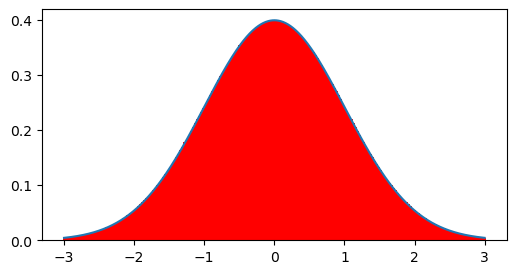

In [18]:
import scipy as sp
Y0 = sp.stats.norm.ppf( np.arange(0,P)/P + 1/(2*P) )
plt.figure(figsize=fs)
display_histogram(Y0)
plt.plot( x, rho(x, 10) );

Implement the backward recursion.

In [19]:
alpha = 0 # pure advection
alpha = .01 # original diffusion is alpha=1
def step(carry, _):
    y_prev, key, t = carry
    key, subkey = jax.random.split(key)
    y_prev = y_prev + tau * ( y_prev + (1+alpha)*score(y_prev,t) ) + jnp.sqrt(2 * tau * alpha) * jax.random.normal(subkey, (P,))
    return (y_prev, key, t-tau), y_prev

# Initialize PRNG key
key = jax.random.PRNGKey(666)
# Perform scan
_, Y = jax.lax.scan(step, (Y0, key, T), jnp.arange(1, N))
# Add initial condition as the first column
Y = jnp.column_stack((Y0, Y.T))

Display the evolution of the density of the law of $Y_{T-t}$. It is close to $\rho_t(x)$, and one can show that it matches exactly when $T \to +\infty$ and $\tau \to 0$.

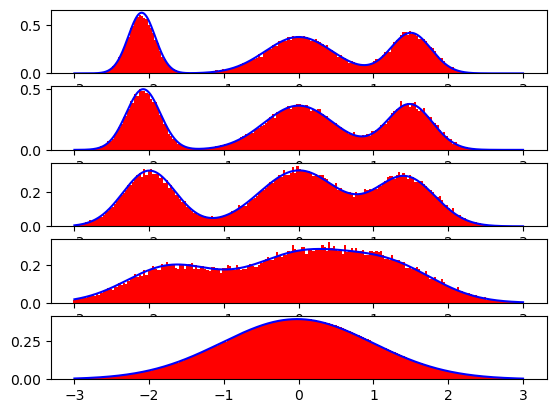

In [20]:
# display evolving density
t_list = T-jnp.array([0, .01, .05, .2, T])
for i in range(len(t_list)):
    s = i/len(t_list)
    t = t_list[i]
    k = np.round( t/tau ).astype(jnp.int32) 
    plt.subplot(len(t_list),1,i+1)
    plt.plot(x,rho(x,T-t), color='blue' )
    display_histogram(Y[:,k])

Displays sample of trajectories $t \mapsto Y_t$.

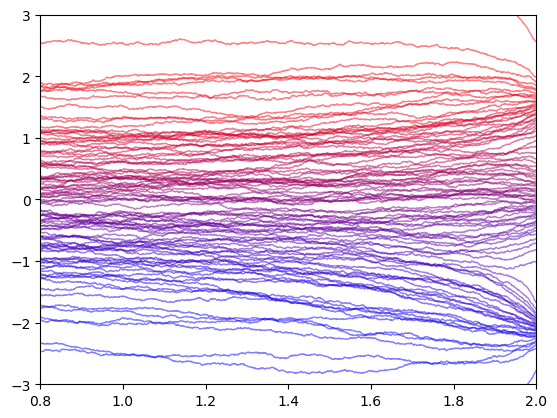

In [21]:
display_trajectories(Y, m=100, alpha=.5, linewidth=1)
plt.axis([.4*T, T, -3, 3]);

## Denoising Score Matching

In order to be able to implement the reverse diffusion, one needs to compute the score $\nabla \log(\rho_t)$, where $\rho_t$ is the density of the distribution of $X_t$. The idea is to approximate this score using a function computed from samples of $X_t$.

$$
	\nabla \log \rho_t(z) \approx \phi_\theta(z,t) 
$$
$$
	\underset{\theta}{\min} \quad \text{Loss}(\theta) 
	:= 
	\int_t \int_x \int_z \| \frac{e^{-t} x - z}{1-e^{-2t}}  - \phi_\theta(z,t) \|^2 \, \text{d} \mathbb{P}(z|x) \text{d} \rho_0(x) \lambda_t \text{d} t
$$
where $\lambda_t$ is a density of sampled time. 

To generate the pairs $(X_0,X_t)$ we first sample $X_0$ and then sample $\mathbb{P}(X_t|X_0)$ which we know in closed form.

In [22]:
N = 20000
X0 = sample_mixture(N, mu,sigma,a)

For the sampling density $\lambda_t$ of time, we use a uniform distribution of time within $[10^{-2},T]$.

In [23]:
Tmin = 1e-1
Tmax = .5
t_list = jnp.linspace(Tmin,Tmax,N)
# map t to the same range as x to ease NN training
def tMap(t): return ( (t-Tmin)/(Tmax-Tmin) - 1/2 ) * 2*xmax
def tMap_inv(z): return ( z/(2*xmax) + 1/2  ) * (Tmax-Tmin) + Tmin

To sample from $\mathbb{P}(X_t|X_0)$, recall that given $X_0$, then $X_t$ can be sampled as
$$
    X_t \sim  e^{-t} X_0 + \sqrt{1-e^{-2t}} Z
$$
where $Z \sim \mathcal{N}(0,1)$.

In [24]:
key = jax.random.PRNGKey(12)  
W = jax.random.normal(key, (N,))
Xt = jnp.exp(-t_list) * X0 + jnp.sqrt(1-jnp.exp(-2*t_list)) * W

In [25]:
Data_in = jnp.vstack((Xt,tMap(t_list))).T
# denoising goal
Data_out = ( jnp.exp(-t_list) * X0 - Xt ) / ( 1-jnp.exp(-2*t_list) )
# ground trust
scoreP = jax.vmap(score) # parallelized version 
# Data_out = scoreP(Xt,t_list)
#plt.plot( Data_in[:,0], Data_in[:,1], '.' )

For $\phi_\theta(z,t)$, we use a Multilayers Perceptron (MLP) layers neural network with input dimension $2$ (for $(z,t)$) and the output should approximate $\frac{e^{-t} x - z}{1-e^{-2t}}$ and has dimension $1$ .The MLP has a varying number of layers and dimensions, encoded in `d_hidden`.

In [26]:
from flax import linen as nn
class MLP(nn.Module):
    d_hidden: list
    d_out: int
    def setup(self):
        self.layers = [nn.Dense(d, use_bias=True) for d in self.d_hidden]
        self.layer_out = nn.Dense(self.d_out, use_bias=True)
    def __call__(self, x):
        for layer in self.layers:
            # x = nn.relu(layer(x))
            x = nn.sigmoid(layer(x))
        x = self.layer_out(x)
        return x

In [27]:
d_in = 2
d_hidden = [50]
d_hidden = [100, 20]
d_hidden = [300, 100, 20]
d_out = 1
model = MLP(d_hidden=d_hidden, d_out=d_out)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, d_in)))

In [28]:
#@jax.jit
def mse_loss(params, model, x, y):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred.flatten() - y.flatten())**2)
#@jax.jit
def update(params, model, x, y, learning_rate):
    loss = mse_loss(params, model, x, y)
    grad_loss = jax.grad(mse_loss)(params, model, x, y)
    updated_params = jax.tree_map(lambda p, g: p - learning_rate * g, params, grad_loss)
    return updated_params, loss

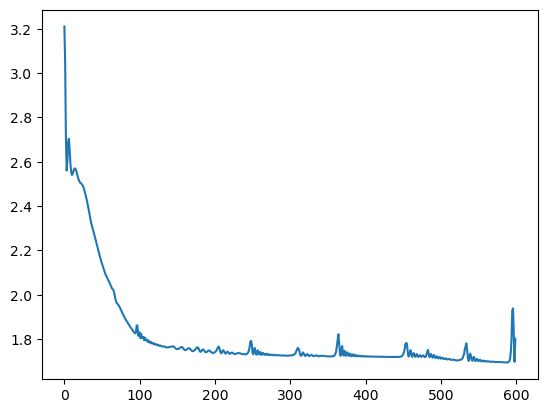

In [29]:
num_epochs = 600
learning_rate = 0.04/2
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, d_in)))
# params['params']['layers_0']['bias'] = np.random.randn( d_hidden[0] ) # init bias randomly 

import optax
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)
loss_list = np.zeros(num_epochs)

for i in range(num_epochs):
    grads = jax.grad(mse_loss)(params, model, Data_in, Data_out)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_list[i] = mse_loss(params, model, Data_in, Data_out)
    
plt.plot(loss_list) 

Evaluate on a grid.

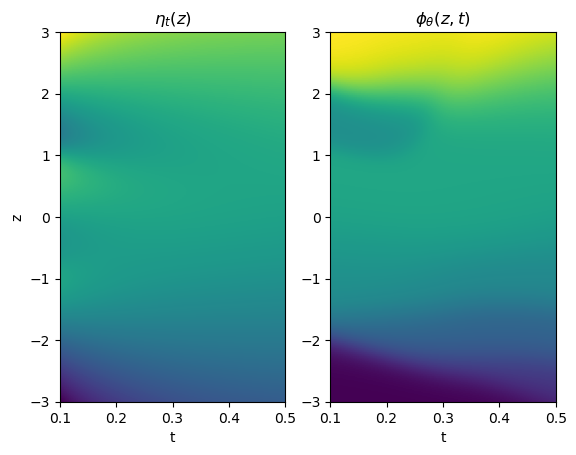

In [30]:
nT = 100
nX = 200
Tlist = jnp.linspace(Tmin,Tmax,nT)
Xlist = jnp.linspace(-xmax,xmax,nX)
A = np.zeros((nX,nT))
B = np.zeros((nX,nT))
for i in range(nT):
    A[:,i] = score( Xlist, Tlist[i] ) # ground trust to predict 
    b = model.apply(params, jnp.vstack((Xlist, Xlist*0+tMap(Tlist[i]) )).T ) # approximation with neural network
    B[:,i] = b.flatten()
plt.subplot(1,2,1)
plt.imshow(A, extent=[Tmin, Tmax, -xmax,xmax], aspect='auto')
plt.title('$\\eta_t(z)$')
plt.ylabel('z')
plt.xlabel('t')
plt.subplot(1,2,2)
plt.imshow(B, extent=[Tmin, Tmax, -xmax,xmax], aspect='auto')
plt.title('$\\phi_{\\theta}(z,t)$')
plt.xlabel('t');